## PEC Procesamiento del Lenguaje natural y Minería de Texto

Profesor: Manuel Lucania

Alumno: Gabriel Ramón España Zapata

DNI:04340129Y

El objetivo de esta PEC es poner en práctica los conocimientos adquiridos en el módulo utilizando como tema **automatización de detección de noticias falsas**. 

Este proceso será llevado a cabo a traves de la implementación de algoritmos de NLP y de Clasificación

Antes que nada, importamos las librerías que se usaron a lo largo de la PEC

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Librerías básicas
import pandas as pd
import numpy as np
from itertools import islice
import operator
import random

# Visualización de datos:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Librerías para NLP:
from sklearn.feature_extraction import _stop_words
import gensim
from gensim.models import Doc2Vec,Phrases
from gensim.models.doc2vec import TaggedDocument
import gensim.downloader as gensim_api
import nltk
from tqdm import tqdm
from sklearn import utils

# Machine Learning:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

Lo siguiente será leer los datos para empezar a tratarlos:
Usaremos los Dataframes de Pandas a lo largo de toda la PEC en muchos casos:

https://towardsdatascience.com/implementing-multi-class-text-classification-with-doc2vec-df7c3812824d
https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d

# Preprocesamiento de los datasets importados:

Se investigó en Kaggle y se encontraron dos datasets con noticias verdaderas y falsas por separado. Esto nos servirá para etiquetarlas como **"true"** a las verdaderas y **"fake"** para las falsas.

Leeremos los mismos con los **DataFrame de Pandas**

In [2]:
df_true = pd.read_csv('./True.csv')
df_true['flag']='true'
df_fake = pd.read_csv('./Fake.csv')
df_fake['flag']='fake'

Mostramos de cada uno un extracto y su composición: (a lo largo de la pec se verá que usamos el random_state=42) buscando que los resultados siempre sean consistentes

In [3]:
df_true.sample(10,random_state=42)

,title,text,subject,date,flag
18137,Europe rights watchdog says Turkey's emergency...,BRUSSELS (Reuters) - A leading European rights...,worldnews,"October 6, 2017",true
3277,Exclusive: Trump targets illegal immigrants wh...,"(Reuters) - In September 2014, Gilberto Velasq...",politicsNews,"June 9, 2017",true
2876,"At G20 summit, Trump pledges $639 million in a...",HAMBURG (Reuters) - U.S. President Donald Trum...,politicsNews,"July 8, 2017",true
5160,Ex-Christie associates lose bid for new trial ...,NEW YORK (Reuters) - A federal judge rejected ...,politicsNews,"March 2, 2017",true
10843,Young blacks more open to Bernie Sanders' Whit...,"ORANGEBURG, S.C. (Reuters) - If Democratic hop...",politicsNews,"February 12, 2016",true
2725,New York attorney general says will sue over O...,(Reuters) - New York state Attorney General Er...,politicsNews,"July 17, 2017",true
12594,Indonesian parliament speaker quits amid graft...,JAKARTA (Reuters) - The speaker of Indonesia s...,worldnews,"December 11, 2017",true
18226,Spanish lender Sabadell to transfer legal base...,MADRID (Reuters) - Spanish lender Sabadell dec...,worldnews,"October 5, 2017",true
4707,House speaker tells Trump healthcare bill lack...,WASHINGTON (Reuters) - U.S. House Speaker Paul...,politicsNews,"March 24, 2017",true
15464,Britain says expects most EU citizens can stay...,LONDON (Reuters) - The British government said...,worldnews,"November 7, 2017",true


In [4]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   flag     21417 non-null  object
dtypes: object(5)
memory usage: 836.7+ KB


In [5]:
df_fake.sample(10,random_state=42)

,title,text,subject,date,flag
13474,ABOUT HILLARY’S COUGH: We Discovered The Secre...,,politics,"Jul 20, 2016",fake
11994,BREAKING: OBAMACARE REPEAL Clears First Hurdle...,The Senate voted 51-48 this afternoon to proce...,politics,"Jan 4, 2017",fake
19179,‘SLEEPY’ JUSTICE GINSBURG: Excites Crowd By Sa...,So much for the SCOTUS not being political Che...,left-news,"Feb 7, 2017",fake
501,WATCH: Kellyanne Conway Very Upset Hillary Cl...,White House counselor Kellyanne Conway crawled...,News,"August 24, 2017",fake
3492,"GOP Gives Trump The Middle Finger, Prepares T...",Donald Trump may have decided that Russia is g...,News,"December 9, 2016",fake
1510,Trump Displays Incredible Ignorance Yet Again...,Have you ever wondered where a phrase started?...,News,"May 11, 2017",fake
3296,Anthony Bourdain Reveals The ‘ONE Good Thing’...,While Donald Trump is currently freaking out b...,News,"December 22, 2016",fake
17798,TRUMP HITS BACK After Cowgirl Congresswoman Tr...,The left is going ballistic over supposed word...,left-news,"Oct 18, 2017",fake
9504,MEDIA DOWNPLAYS Attack By Unhinged Neighbor On...,"5 broken ribs with trouble breathing, lung con...",politics,"Nov 6, 2017",fake
6087,Why This Attorney General Is Going After Trum...,New York Attorney General Eric Schneiderman is...,News,"May 31, 2016",fake


In [6]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   flag     23481 non-null  object
dtypes: object(5)
memory usage: 917.4+ KB


Para iniciar el procesamiento de los dataframes queremos aseguramos de limpiar las filas que tienen valores NA y aquellas que tienen duplicados en los títulos y en los textos.

In [7]:
def limpieza_df(df):
    
    # Eliminamos los registros con valores NA
    df.dropna(inplace=True)
    
    # Eliminamos los registros con títulos duplicados
    df.drop_duplicates(subset=['title'], inplace=True)

    # Eliminamos los registros con textos duplicados
    df.drop_duplicates(subset=['text'], inplace=True)
    
    print("New shape:", df.shape)
    return df.sample(10,random_state=42)

In [8]:
limpieza_df(df_true)

New shape: (20821, 5)


,title,text,subject,date,flag
2517,Trump transgender decision 'shocking and ignor...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"July 26, 2017",true
8726,Art of the spin: Trump bankers question his po...,"NEW YORK (Reuters) - Donald Trump, who often s...",politicsNews,"July 17, 2016",true
16510,Italian government wins all five confidence vo...,ROME (Reuters) - The Italian government won al...,worldnews,"October 25, 2017",true
21330,Suicide attack on Kabul Shi'ite mosque kills a...,KABUL (Reuters) - A suicide bomber blew himsel...,worldnews,"August 25, 2017",true
9441,Obama confident Pacific trade deal will be app...,HANOI (Reuters) - U.S. President Barack Obama ...,politicsNews,"May 23, 2016",true
19009,"Kremlin, after Kurdish vote, says supports int...",MOSCOW (Reuters) - The Kremlin on Tuesday sign...,worldnews,"September 26, 2017",true
19110,Brexit can be 'comfortably' negotiated in two ...,PRAGUE (Reuters) - Britain can negotiate its e...,worldnews,"September 25, 2017",true
5847,Travel ban protest delays Senate panel vote on...,WASHINGTON (Reuters) - U.S. Senate Democrats d...,politicsNews,"January 30, 2017",true
14576,Trump discussed free trade pact with Japan's A...,TOKYO (Reuters) - President Donald Trump discu...,worldnews,"November 17, 2017",true
7870,Locker room talk? Key women voters call foul o...,WASHINGTON/NEW YORK (Reuters) - U.S. Republica...,politicsNews,"October 11, 2016",true


In [9]:
limpieza_df(df_fake)

New shape: (17450, 5)


,title,text,subject,date,flag
15543,GOP PRESIDENTIAL CANDIDATE MARCO RUBIO CASTS D...,One more Republican doing his part to aid Obam...,politics,"Jun 23, 2015",fake
1355,BREAKING: FBI Suspects Jared Kushner Of Being...,It was recently reported that someone within t...,News,"May 25, 2017",fake
9145,JUST IN: FORMER NBC NEWS ANCHOR Tom Brokaw Tel...,"This morning, President Trump tweeted a note o...",politics,"Dec 21, 2017",fake
19,Republican Senator Gets Dragged For Going Aft...,Senate Majority Whip John Cornyn (R-TX) though...,News,"December 16, 2017",fake
10276,FARMER FINED A WHOPPING $2.8 MILLION Asks Pres...,A California farmer fined $2.8 million for plo...,politics,"Jul 29, 2017",fake
13479,WATCH RUDY GIULIANI Rock The Crowd In Clevelan...,In case you missed this Rudy Giuliani delivere...,politics,"Jul 20, 2016",fake
14903,Three Ways We React To ISIS That Plays Right I...,This is a very interesting article and worth t...,politics,"Nov 22, 2015",fake
4465,HuffPo Just Dropped The Mic On Internet Polls...,The earliest actual poll to come out of last n...,News,"September 27, 2016",fake
6096,RNC’s Hilariously Delusional Election Model P...,The Republican Party is not well we know it ...,News,"May 31, 2016",fake
11979,"OBAMA’S Mexico Gun-Running, Race-Baiting, Form...",Eric Holder was embroiled in some sort of cont...,politics,"Jan 7, 2017",fake


Por último, concatenamos los dataframes y reseteamos los índices:

In [10]:
df = pd.concat([df_true, df_fake], axis=0)
df = df.reset_index(drop=True)
df.sample(10,random_state=42)

,title,text,subject,date,flag
16355,Catalan leader to lose all powers once Senate ...,MADRID (Reuters) - Regional leader of Cataloni...,worldnews,"October 23, 2017",true
13862,"Mladic will appeal conviction, sentence",THE HAGUE (Reuters) - Former Bosnian Serb mili...,worldnews,"November 22, 2017",true
21366,Watch This Nazi Cry Like A Little B*tch After...,"Christopher Cantwell, one of the Nazis feature...",News,"August 16, 2017",fake
1465,U.S. preparing plan to draw down embassy staff...,WASHINGTON (Reuters) - The United States is cr...,politicsNews,"September 28, 2017",true
5908,Trump spoke to Mexican president on Friday: Wh...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"January 27, 2017",true
38061,Boiler Room EP #72 – Trailer Parks in Heaven,Tune in to the Alternate Current Radio Network...,US_News,"September 3, 2016",fake
23858,"Susan Collins Bucked Party, Voted To Protect ...",Even though Senator Susan Collins voted with t...,News,"January 12, 2017",fake
27678,This ‘Do Your Job’ Video Is Humiliating GOP S...,"We pay our senators $174,000 per year. For tha...",News,"April 17, 2016",fake
38064,SpaceX: Explosion Rocks Launchpad at Firm’s Ca...,21st Century Wire says The privatization of ...,US_News,"September 1, 2016",fake
16169,Australia campuses warned of 'clandestine' inf...,SYDNEY (Reuters) - Australia s domestic spy ch...,worldnews,"October 25, 2017",true


El objetivo en adelante pasa a ser: **predecir la variable flag a través del título de una noticia**. Lo bueno y simple de esto es que a futuro se puede usar el mismo código para evaluar titulares de noticias de un portal haciendo web scrapping:

Entonces, deberemos procesar y transformar la variable "title" de nuestro dataframe para poder alimentar los algoritmos de NLP y luego de Categorización

In [11]:
# Se explica más adelante el posible uso de esta línea de código
#df['title_text']=df['title']+" "+df['text'] 

# Limpieza de los textos

Vamos a "limpiar" los strings de los títulos, a través de expresiones regulares, retirando todo signo de puntuación, números, espacios en blanco de sobra (todo lo que no sea palabra separadas por un espacios) y pasar a minúsculas 

In [12]:
def limpieza_textos(df,column):
    
    # Eliminamos signos de puntuación
    df[column] = df[column].str.replace('[^\w\s]',' ')

    # Eliminamos números 
    df[column] = df[column].str.replace('[^A-Za-z]',' ')

    # Eliminamos los posibles doble espacios
    df[column] = df[column].str.replace('  ',' ')
    df[column]= df[column].str.replace('  ',' ')

    # pasamos los textos a minúsculas
    df[column] = df[column].str.lower()
    
    print("New shape:", df.shape)
    return df.sample(10,random_state=42)

In [13]:
limpieza_textos(df,'title')
#limpieza_textos(df,'title_text')

New shape: (38271, 5)


,title,text,subject,date,flag
16355,catalan leader to lose all powers once senate ...,MADRID (Reuters) - Regional leader of Cataloni...,worldnews,"October 23, 2017",true
13862,mladic will appeal conviction sentence,THE HAGUE (Reuters) - Former Bosnian Serb mili...,worldnews,"November 22, 2017",true
21366,watch this nazi cry like a little b tch after...,"Christopher Cantwell, one of the Nazis feature...",News,"August 16, 2017",fake
1465,u s preparing plan to draw down embassy staff ...,WASHINGTON (Reuters) - The United States is cr...,politicsNews,"September 28, 2017",true
5908,trump spoke to mexican president on friday whi...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"January 27, 2017",true
38061,boiler room ep trailer parks in heaven,Tune in to the Alternate Current Radio Network...,US_News,"September 3, 2016",fake
23858,susan collins bucked party voted to protect k...,Even though Senator Susan Collins voted with t...,News,"January 12, 2017",fake
27678,this do your job video is humiliating gop sen...,"We pay our senators $174,000 per year. For tha...",News,"April 17, 2016",fake
38064,spacex explosion rocks launchpad at firm s cap...,21st Century Wire says The privatization of ...,US_News,"September 1, 2016",fake
16169,australia campuses warned of clandestine influ...,SYDNEY (Reuters) - Australia s domestic spy ch...,worldnews,"October 25, 2017",true


# Breve análisis de las otras variables

La variable **textos**, sería interesante tenerala en cuenta para nuestro análisis. Realizando un concatenado de las variables title y text (procesando todo como una misma variable) podríamos obtener mejores resultados. 

En el sample anterior vemos como las noticias verdaderas suelen comenzar con el nombre de la fuente (Por ejemplo: reuters) y las falsas no. 

En cuanto a la variable de las fechas, no parece interesar para el análisis de determinación si es verdadera o no.

Otra variable que podía haber ayudado a los modelos de categorización, es si se conociera la fuente de todas las noticias. Aquí no estaríamos realizando un análisis de NLP, pero si lo tendríamos en cuenta para predecir la veracidad de las noticias en función del sitio que provienen

Por último, una variable que si podemos analizar en detenimiento es el tema: Vamos a analizar las tablas de frecuencias de las categorías de noticias "subject" vs si es verdadera o falsa.

In [14]:
(pd.crosstab(df['flag'], df['subject']))

subject,Government News,News,US_News,left-news,politics,politicsNews,worldnews
flag,,,,,,,
fake,514,9049,783,683,6421,0,0
true,0,0,0,0,0,11147,9674


Estos resultados muestran una evidencia de que en función del subject se podría predecir si la noticia es falsa o verdadera. Pero posiblemente sea por el dataset en si. Así que no tendremos en cuenta esta variable para el análisis ya que estaríamos "ayudandolo" a predecir.

Finalmente, eliminamos del dataframe las columnas que no tendremos en cuenta para el procesamiento NLP y categorización

In [15]:
df.drop(["subject","text","date"],axis=1,inplace=True)
#df.drop(["title","subject","text","date"],axis=1,inplace=True)

**Nota importante:** Volviendo a la alternativa de incorporar el texto de las noticias a nuestro análisis, esto se hubiera realizado concatenando el titular más el texto de las noticias. Ciertamente hubiera enriquecido el entrenamiento del modelo al tener más información y diferenciación entre las noticias verdaderas y falsas.

Se intentó modelar de esta manera, pero la función de preprocesamiento_texto() aplicado a todo el titulo + texto se excedía en tiempo.

En las tareas limpieza y preprocesamiento de los textos reemplazaríamos el uso de la columna df['title'] por df['title_text']. Siendo df['title_text']=df['title']+" "+df['text']. Queda #comentado como sería el código a lo largo de la PEC

De esta manera la predicción de si la noticia es verdadera o falsa tendría en cuenta ambas variables. 

# Modelado

Una parte importante para trabajar con NLP es obtener los **lemas** de las palabras. Para esto, creamos una función que para cada texto lo **toquenice**, **limpiamos las "stopwords"** del propio idioma que no serán significativas para el análisis y por último obtenemos los **stemmings**:

In [16]:
def procesamiento_texto(title):
    #Toquenizamos:
    list_title=title.split()
    
    #Eliminamos las Stopwords en ingles:
    list_title=[word for word in list_title if word not in nltk.corpus.stopwords.words("english")]
    
    #Obtenemos los stemmings:
    aux=nltk.stem.porter.PorterStemmer()
    list_title=[aux.stem(word)for word in list_title]
    
    #Obtenemos los lemas:
    lemmas=nltk.stem.wordnet.WordNetLemmatizer()
    list_title=[lemmas.lemmatize(word) for word in list_title]
    
    #Volvemos a frase:
    title=" ".join(list_title)
    return title

Aplicamos esta función al data frame actual a traves de la combinación de **apply - lamda:**

In [17]:
df['title_clean']=df['title'].apply(lambda x: procesamiento_texto(x))
#df['title_text_clean']=df['title_text'].apply(lambda x: procesamiento_texto(x))

Por último convertimos cada string de textos en **listas de lemas:** en la columna "title_clean_grams"

In [18]:
df['title_clean_grams']=df['title_clean'].apply(lambda x: x.split())
#df['title_text_clean_grams']=df['title_text_clean'].apply(lambda x: x.split())
df.sample(10)

,title,flag,title_clean,title_clean_grams
24626,know nothing trump reverses yet another posit...,fake,know noth trump revers yet anoth posit foreign...,"[know, noth, trump, revers, yet, anoth, posit,..."
29358,grand jury indicts anti choice zealots who pr...,fake,grand juri indict anti choic zealot produc pho...,"[grand, juri, indict, anti, choic, zealot, pro..."
11617,venezuela s maduro says terrorists stole weapo...,true,venezuela maduro say terrorist stole weapon mi...,"[venezuela, maduro, say, terrorist, stole, wea..."
8857,in campaign trail debut with clinton warren sa...,true,campaign trail debut clinton warren say trump ...,"[campaign, trail, debut, clinton, warren, say,..."
10478,hecklers disrupt trump rally photographer shov...,true,heckler disrupt trump ralli photograph shove g...,"[heckler, disrupt, trump, ralli, photograph, s..."
33378,tonight s first presidential debate what time ...,fake,tonight first presidenti debat time watch insi...,"[tonight, first, presidenti, debat, time, watc..."
4199,north korean official says will continue missi...,true,north korean offici say continu missil test bbc,"[north, korean, offici, say, continu, missil, ..."
14805,u s s tillerson concerned over saudi purge mon...,true,u tillerson concern saudi purg monitor hariri ...,"[u, tillerson, concern, saudi, purg, monitor, ..."
11411,pakistan closes ngos in what activists see as ...,true,pakistan close ngo activist see widen crackdown,"[pakistan, close, ngo, activist, see, widen, c..."
29186,nazi ranting man accosts msnbc host at iowa c...,fake,nazi rant man accost msnbc host iowa caucu,"[nazi, rant, man, accost, msnbc, host, iowa, c..."


Brevemente también podemos hacer **mostrar los bigrams** presentes en el corpus tota con sus respecivos Scores. Usamos el algoritmo **Phrases**, también presente en gensim models

In [19]:
bigram_model=Phrases(df['title_clean_grams'])
#bigram_model=Phrases(df['title_text_clean_grams'])
phrases_bigram=bigram_model.export_phrases()
pd.Series(sorted(phrases_bigram.items(),key=operator.itemgetter(1),reverse=True)).head(10)

0            (valeri_jarrett, 10204.25)
1      (bett_midler, 9920.798611111111)
2       (pena_nieto, 9660.828402366864)
3         (lou_dobb, 9660.828402366864)
4       (salli_yate, 9157.660256410256)
5                (dinesh_souza, 8746.5)
6        (sri_lanka, 8503.541666666666)
7    (degrass_tyson, 8503.541666666666)
8               (patton_oswalt, 8330.0)
9             (meryl_streep, 8253.4375)
dtype: object

Como buena práctica para evaluar los modelos de machine learning (ya sea nlp o de categorización) **dividimos el dataset en entrenamiento y test:**

In [20]:
df_train,df_test=train_test_split(df,random_state=42)

Para poder alimentar un modelo de categorización de machine learning teniendo frases y textos **necesitamos vectorizar los mismos.** Para esto usaremos el **Modelo Doc2Vec**, de gensim models, basado en **Deep Learning** que utilizan redes neuronales por debajo
- Este modelo supera el simple promedio de vecotres Word2Vec. Se considera una extensión de word2vec ya que aprende a correlacionar etiquetas y palabras, en lugar de palabras con palabras.
- Los textos que se le pasan para crear, entrenar y predecir deben estar en formato **TaggedDocument** que es una lista de los tokens que componen el texto y luego seguido de su etiqueta (flag). Lo favorable de este algorirmo es que no te exige que la "bandera" sea un valor númerico o booleano, puede ser un string. Por lo tanto, los dejamos como "true" y "fake"

Entonces, **generamos las listas de TaggedDocuments** para los datasets de df_train (documents_training) y df_test (documents_test):

In [21]:
documents_training=[]
documents_test=[]
for i in range(len(df_train)):
    documents_training.append(TaggedDocument(df_train['title_clean_grams'].iloc[i],df_train['flag'].iloc[i]))
    #documents_training.append(TaggedDocument(df_train['title_text_clean_grams'].iloc[i],df_train['flag'].iloc[i]))
for j in range(len(df_test)):
    documents_test.append(TaggedDocument(df_test['title_clean_grams'].iloc[j],df_test['flag'].iloc[j]))
    #documents_test.append(TaggedDocument(df_test['title_text_clean_grams'].iloc[j],df_test['flag'].iloc[j]))

Ahora, ya podemos crear el modelo Doc2Vec, lo haremos con los siguientes **parametros** y sin pasarle de inicio los textos:
- dm=1 (Implementación de algoritmo con memoria distribuida) (PV-DM).
- vector_size=300 - Dimensionalidad de los vectores
- negative=5 - da uso al dibujo de "noise words" - mejor performance
- hs=0 - requerido para cuando usamos el parámetro negative.
- min_count=2 (ingora todas las palabras que no se repitan almenos una vez)
- sample=0
- alpha= 0.025 - ratio de aprendizaje (bajo)
- min_alpha =0.001 - como va bajando el ratio de aprendizaje a medida que avanza el entrenamiento
- seed=42 - semilla para que los datos sean consistentes.

Segundo, creamos su vocabulario asignandole la secuencia de los taggedDocuments que generamos anteriormente y guardamos en la variable documents_training.

Tercero, último entrenamos el modelo con los siguientes parámetros:
- corpus_iterable=documents_training
- total_examples= número de documentos que le pasamos.
- epochs=40 (número de iteraciones para entrenar)

Por último, salvamos el modelo.

In [22]:
model_doc2vec = Doc2Vec(dm=1, vector_size=300,seed=42, negative=5, hs=0, min_count=2, sample = 0, alpha=0.025, min_alpha=0.001)
model_doc2vec.build_vocab([x for x in tqdm(documents_training)])
model_doc2vec.train(documents_training,total_examples=len(documents_training), epochs=40)

model_doc2vec.save('./model_doc2vec_pec.d2v')
#luego de salvarlo podríamos volver a cargarlo con el método load.

100%|██████████| 28703/28703 [00:00<00:00, 2613404.85it/s]


Teniendo el modelo de vectorización ya entrenado, ahora podemos obtener las variables X e Y de entrenamiento y test que alimentarán el modelo de machine learning:

Creamos la función de vector_ml que devuelve los vectores target (1 si es verdadera, 0 si es falsa la noticia) y los vectores que genera el modelo entrenado a traves del metodo .infer_vector(palabras,steps=20) 

In [23]:
def vector_ml(model, input_docs):
    sents = input_docs
    targets, text_vectors = zip(*[(int(doc.tags=='true'), model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, text_vectors

In [24]:
y_train, X_train = vector_ml(model_doc2vec, documents_training)
y_test, X_test = vector_ml(model_doc2vec, documents_test)

Estos set de datos transformados ya están listos para usarse en el modelo de categorización

## Algunas operaciones que podemos efectuar con el modelo de vectorización:
Por ejemplo, veamos la frecuencia de la palabra "crime" en nuestro modelo entrenado:

In [25]:
print(f"La palabra 'crime' apareció {model_doc2vec.wv.get_vecattr('crime', 'count')} veces en el corpus de entrenamiento.")

La palabra 'crime' apareció 96 veces en el corpus de entrenamiento.


Le pasamos una serie de palabras y nos indica cual no es parte del conjunto

In [26]:
model_doc2vec.wv.doesnt_match("trump crime help america".split())

'crime'

También podemos pedirle que nos indique cuales son las palabras más similares a una indicada:

In [27]:
model_doc2vec.wv.most_similar("crime")

[('crimin', 0.6401203274726868),
 ('croat', 0.5844037532806396),
 ('feloni', 0.5310614109039307),
 ('act', 0.5029081106185913),
 ('convict', 0.49788305163383484),
 ('adult', 0.48467862606048584),
 ('philando', 0.4841691553592682),
 ('vietnames', 0.4662694036960602),
 ('castil', 0.46426376700401306),
 ('alien', 0.46144476532936096)]

# Modelo de Machine Learning:

Vamos a buscar cual es la mejor modelo para clasificar las fake news:

Para los diversos modelos evaluaremos las métricas de precisión, exactitud y exhaustividad. El área bajo la curva mediante ROC_AUC que da una idea de la precisión del modelo.

Generamos una función que devuelve las mismas:


In [28]:
def metricas_modelos(y_true, y_pred):
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)

    print('La matriz de confusión es ')
    print(confusion_matrix)

    print('Precisión:', accuracy_score(y_true, y_pred))
    print('Exactitud:', precision_score(y_true, y_pred))
    print('Exhaustividad:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print('AUC:', auc(false_positive_rate, recall))

    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

**Regresión logística:**

Buscaremos ayudarnos para la selección de los hiperparámetros a traves del uso del algoritmo GridSearchCV:

In [29]:
log_reg=LogisticRegression(random_state=42)
log_reg_params={'solver':np.array(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),#le pasamos todos los tipos
               'fit_intercept':np.array([True,False]),#dando la opción de tome o no la constante.
               'C':np.array([1,0.1,0.01])}#jugamos con posibles valores que harían más fuerte el ajuste.

grid_log_reg = GridSearchCV(log_reg, 
                            log_reg_params,
                            cv = 3,#probamos un crossover de 3
                            return_train_score = True)#que devuelva el score del training.

grid_log_reg.fit(X_test,y_test)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid_log_reg.best_params_)
print('El mejor score es', grid_log_reg.best_score_)

El mejor parametro es {'C': 0.1, 'fit_intercept': True, 'solver': 'liblinear'}
El mejor score es 0.8511707400668377


Creamos el modelo de Regresión Logística según los mejores hiperparámetros:
Luego entrenamos y predecimos para obtener las métricas.

Las métricas para según los datos de test son:
La matriz de confusión es 
[[3323 1021]
 [ 455 4769]]
Precisión: 0.8457357859531772
Exactitud: 0.8236614853195164
Exhaustividad: 0.9129019908116386
F1: 0.865988741601598
AUC: 0.8389325791995578


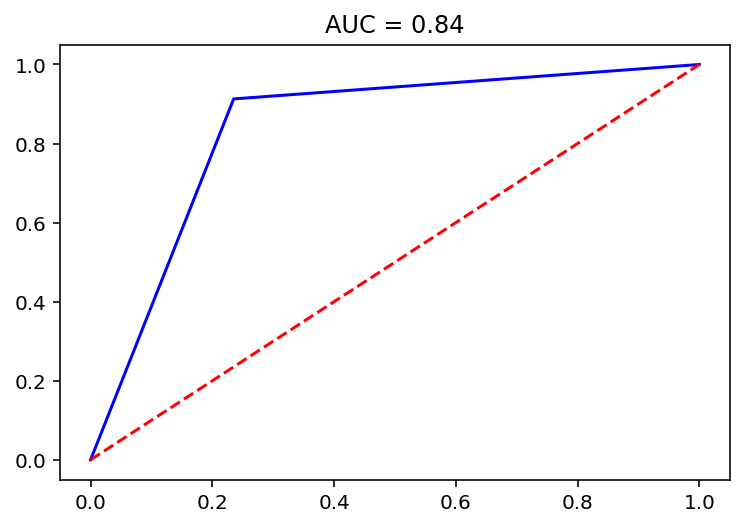

In [30]:
log_reg=LogisticRegression(solver=grid_log_reg.best_params_['solver'],
                           fit_intercept=grid_log_reg.best_params_['fit_intercept'],
                           C=grid_log_reg.best_params_['C'],
                           random_state=42)
log_reg.fit(X_train,y_train)

y_pred_log_reg=log_reg.predict(X_test)

print("Las métricas para según los datos de test son:")
metricas_modelos(y_test,y_pred_log_reg)

**Árboles de decisión:**

In [31]:
dt_classifier=DecisionTreeClassifier(random_state=42)
dt_classifier_params={'criterion':np.array(['gini', 'entropy']), #Que elija el criterio de selección
               'max_depth':np.array([2,3,4])}#Limitamos la profundidad del arbol.
            
grid_dt_classifier = GridSearchCV(dt_classifier, 
                            dt_classifier_params,
                            cv = 3,#probamos un crossover de 3
                            return_train_score = True)#que devuelva el score del training.

grid_dt_classifier.fit(X_test,y_test)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid_dt_classifier.best_params_)
print('El mejor score es', grid_dt_classifier.best_score_)

El mejor parametro es {'criterion': 'gini', 'max_depth': 4}
El mejor score es 0.7540765293968654


Las métricas para según los datos de test son:
La matriz de confusión es 
[[2579 1765]
 [ 568 4656]]
Precisión: 0.7561663879598662
Exactitud: 0.7251206977106369
Exhaustividad: 0.891271056661562
F1: 0.7996565049377414
AUC: 0.7424817530084974


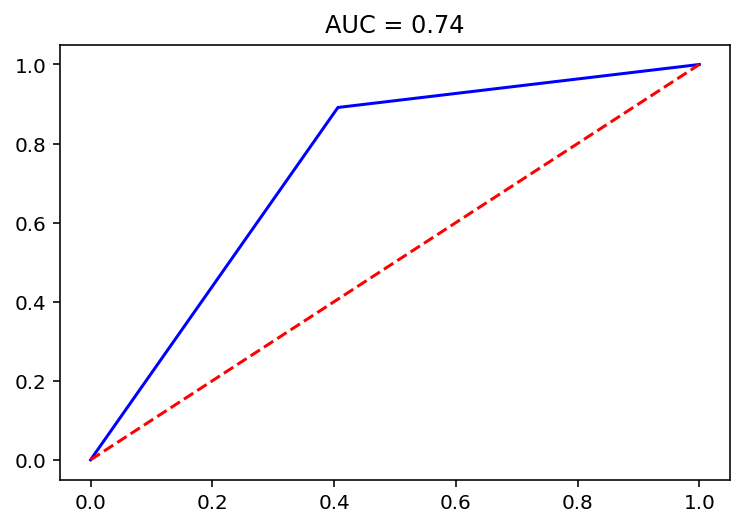

In [32]:
dt_classifier=DecisionTreeClassifier(criterion=grid_dt_classifier.best_params_['criterion'],
                                     max_depth=grid_dt_classifier.best_params_['max_depth'],
                                     random_state=42)
dt_classifier.fit(X_train,y_train)

y_pred_dt_classifier=dt_classifier.predict(X_test)

print("Las métricas para según los datos de test son:")
metricas_modelos(y_test,y_pred_dt_classifier)

**Random Forest**

In [33]:
forest=RandomForestClassifier(random_state=42)
forest_params={'criterion':np.array(['gini', 'entropy']), #Que elija el criterio de selección
               'max_depth':np.array([2,3,4]),#Limitamos la profundidad del arbol para evitar sobre ajuste
                'n_estimators':np.array([5,7,10])}#Forzamos la creación de varios arboles con el parámetro n_estimators
            
grid_forest = GridSearchCV(forest, 
                            forest_params,
                            cv = 3,#probamos un crossover de 3
                            return_train_score = True)#que devuelva el score del training.

grid_forest.fit(X_test,y_test)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid_forest.best_params_)
print('El mejor score es', grid_forest.best_score_)

El mejor parametro es {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 10}
El mejor score es 0.8005845918227922


Las métricas para según los datos de test son:
La matriz de confusión es 
[[2767 1577]
 [ 360 4864]]
Precisión: 0.7975543478260869
Exactitud: 0.7551622418879056
Exhaustividad: 0.9310872894333844
F1: 0.8339477068152593
AUC: 0.784028911751683


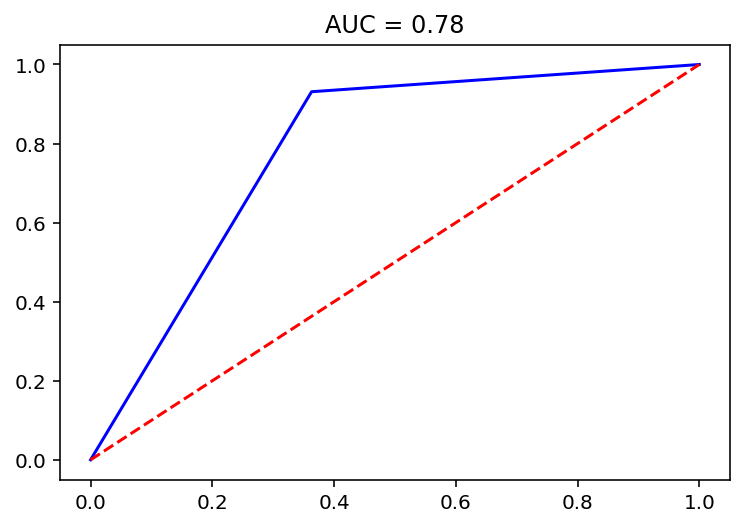

In [34]:
forest=RandomForestClassifier(criterion=grid_forest.best_params_['criterion'],
                              max_depth=grid_forest.best_params_['max_depth'],
                              n_estimators=grid_forest.best_params_['n_estimators'],
                              random_state=42)
forest.fit(X_train,y_train)

y_pred_forest=forest.predict(X_test)

print("Las métricas para según los datos de test son:")
metricas_modelos(y_test,y_pred_forest)

**Support Vector Machine o SMV** 
Las máquinas de vector soporte (SVM, Support Vector Machines) son algoritmos de aprendizaje supervisado que se pueden utilizar tanto para resolver problemas de clasificación como de regresión. Las SVM dibujan un hiperplano entre dos grupos de datos de forma que se maximice el margen entre los conjuntos de puntos.
**Ojo: la línea de código que sigue demora bastante en finalizar la ejecución**

In [35]:
clf=SVC(random_state=42)
clf_params={'kernel':np.array(['poly', 'rbf', 'sigmoid']), #Que elija el núcleo de selección
               'gamma':np.array([0.1,0.5]),
                'degree':np.array([2,3])}#damos a elección los grados
            
grid_clf = GridSearchCV(clf, 
                            clf_params,
                            cv = 2,#probamos un crossover de 2 para bajar el tiempo de procesamiento
                            return_train_score = True)#que devuelva el score del training.

grid_clf.fit(X_test,y_test)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid_clf.best_params_)
print('El mejor score es', grid_clf.best_score_)

El mejor parametro es {'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
El mejor score es 0.8765677257525084


Las métricas para según los datos de test son:
La matriz de confusión es 
[[3826  518]
 [ 761 4463]]
Precisión: 0.8663252508361204
Exactitud: 0.8960048183095763
Exhaustividad: 0.8543261868300153
F1: 0.8746692797648211
AUC: 0.8675406256433686


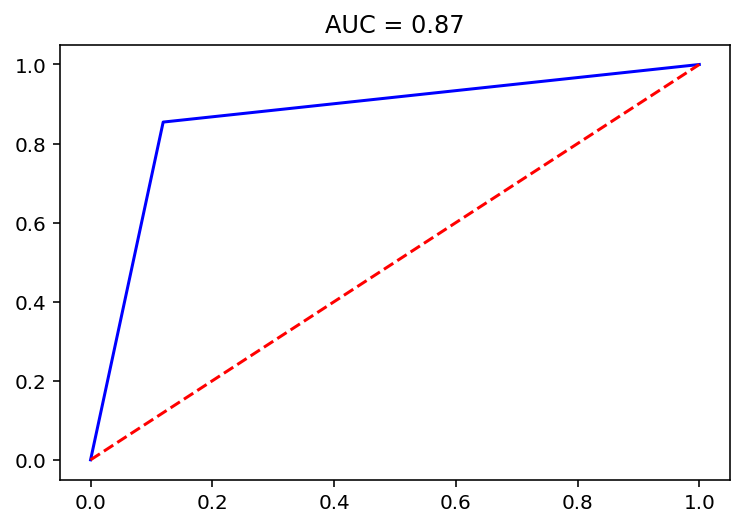

In [36]:
clf=SVC(kernel=grid_clf.best_params_['kernel'],
        degree=grid_clf.best_params_['degree'],
        gamma=grid_clf.best_params_['gamma'],
        random_state=42)
clf.fit(X_train,y_train)

y_pred_clf=clf.predict(X_test)

print("Las métricas para según los datos de test son:")
metricas_modelos(y_test,y_pred_clf)

**Vecinos más Cercanos:**
Usaremos el KneighborsClassifier

In [37]:
kn_classifier=KNeighborsClassifier()
kn_classifier_params={'n_neighbors':np.array([2,3,4,5])} #Variamos los posibles vecinos

grid_kn_classifier = GridSearchCV(kn_classifier, 
                            kn_classifier_params,
                            cv = 3,#probamos un crossover de 3
                            return_train_score = True)#que devuelva el score del training.

grid_kn_classifier.fit(X_test,y_test)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid_kn_classifier.best_params_)
print('El mejor score es', grid_kn_classifier.best_score_)

El mejor parametro es {'n_neighbors': 4}
El mejor score es 0.7449828351310819


Las métricas para según los datos de test son:
La matriz de confusión es 
[[3009 1335]
 [ 675 4549]]
Precisión: 0.7899247491638796
Exactitud: 0.7731135282121007
Exhaustividad: 0.8707886676875957
F1: 0.8190493338134678
AUC: 0.7817341128493226


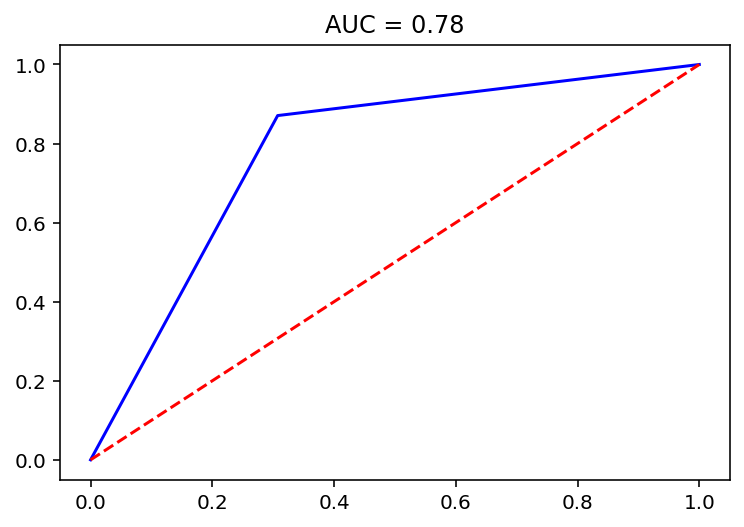

In [38]:
kn_classifier=KNeighborsClassifier(n_neighbors=grid_kn_classifier.best_params_['n_neighbors'])
kn_classifier.fit(X_train,y_train)

y_pred_kn_classifier=kn_classifier.predict(X_test)

print("Las métricas para según los datos de test son:")
metricas_modelos(y_test,y_pred_kn_classifier)

## Conclusiones:

Vemos que el mejor algoritmo de clasificación que se ajusta a este set de datos transformados es el de Máquina de vector soporte con los parámetros:

In [39]:
print(grid_clf.best_params_)

{'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


El siguiente con mejor puntaje sería el de regresión logística con los parámetros:

In [40]:
print('El mejor parametro es', grid_log_reg.best_params_)

El mejor parametro es {'C': 0.1, 'fit_intercept': True, 'solver': 'liblinear'}


Por último, podemos elegir al azar una noticia del set de datos de test, visualizamos su titular toquenizado y mostramos la predicción ya calculada anteriormente:

In [41]:
noticia=random.randint(0,len(documents_test))

print("La noticia es:\n",documents_test[noticia])

if y_pred_clf[noticia]:
    print("\nEl mejor algoritmo de clasificación predijo que esta noticia es verdadera")
else:
    print("\nEl mejor algoritmo de clasificación predijo que esta noticia es falsa")

La noticia es:
 TaggedDocument(['two', 'dead', 'sever', 'wound', 'stab', 'southern', 'dutch', 'citi', 'maastricht', 'polic'], true)

El mejor algoritmo de clasificación predijo que esta noticia es verdadera
